# SVM implementation using CVXOpt

Nipun Batra  
2024-04-12

This post is pretty much borrowed with slight modifications from this
excellent [blog post](https://gist.github.com/mblondel/586753) from
Matthieu Blondel

### General QP problem

A general QP problem can be formulated as follows:

$$
\begin{align*}
\text{minimize} \quad & \frac{1}{2} x^T P x + q^T x \\
\text{subject to} \quad & G x \leq h \\
& A x = b
\end{align*}
$$

### Solving in Dual

In dual in hard margin SVM, the dual problem is formulated as follows:

$$
\begin{align*}
\text{maximize} \quad & \sum_{i=1}^{m} \alpha_i - \frac{1}{2} \sum_{i=1}^{m} \sum_{j=1}^{m} \alpha_i \alpha_j y^{(i)} y^{(j)} (x^{(i)})^T x^{(j)} \\
\text{subject to} \quad & \alpha_i \geq 0 \quad \text{for} \quad i = 1, 2, \ldots, m \\
& \sum_{i=1}^{m} \alpha_i y^{(i)} = 0
\end{align*}
$$

Or, we can write it in the following form (minimization problem): $$
\begin{align*}
\text{minimize} \quad & \frac{1}{2} \alpha^T Q \alpha + e^T \alpha \\
\text{subject to} \quad & y^T \alpha = 0 \\
& \alpha \geq 0
\end{align*}
$$

where $$
\begin{align*}
Q_{ij} & = y^{(i)} y^{(j)} (x^{(i)})^T x^{(j)} \\
e_i & = -1
\end{align*}
$$

we can again write it in the following form using kernel trick:

$$
Q_{ij} = y^{(i)} y^{(j)} K(x^{(i)}, x^{(j)})
$$

where $K(x^{(i)}, x^{(j)}) = (x^{(i)})^T x^{(j)}$ is the kernel
function.

Thus, we can now set $$
\begin{align*}
P & = Q \\
q & = e \\
G & = -I \\
h & = 0 \\
A & = y^T \\
b & = 0
\end{align*}
$$

where $I$ is the identity matrix.

In [108]:
try: 
    import cvxopt
    import cvxopt.solvers

except:
    %pip install cvxopt
    import cvxopt
    import cvxopt.solvers

import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [117]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-np.linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

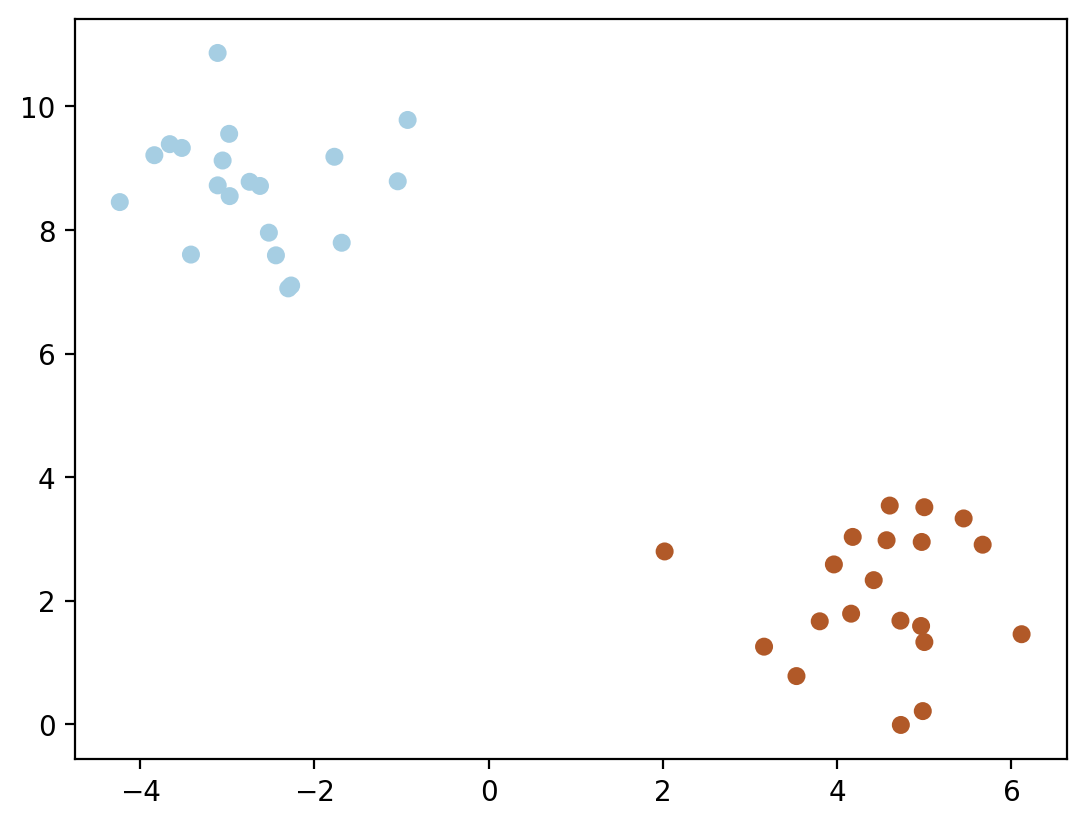

In [124]:
X, y = make_blobs(n_samples=40, centers=2, n_features=2, random_state=42)

y[y == 0] = -1.0
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

In [125]:
n_samples, n_features = X.shape
kernel = linear_kernel

# Gram matrix
K = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_samples):
        K[i,j] = kernel(X[i], X[j])

In [126]:
# QP problem formulation
P = cvxopt.matrix(np.outer(y, y) * K)
q = cvxopt.matrix(-np.ones(n_samples))
A = cvxopt.matrix(y, (1, n_samples), 'd')
b = cvxopt.matrix(0.0)
G = cvxopt.matrix(-np.eye(n_samples))
h = cvxopt.matrix(np.zeros(n_samples))

In [127]:
dictionary = {"P": P, "q": q, "A": A, "b": b, "G": G, "h": h}
for key, val in dictionary.items():
    print(key, val.size)

P (40, 40)
q (40, 1)
A (1, 40)
b (1, 1)
G (40, 40)
h (40, 1)

In [130]:
solution = cvxopt.solvers.qp(P, q, G, h, A, b)

     pcost       dcost       gap    pres   dres
 0: -1.4386e+00 -2.2358e+00  8e+01  8e+00  2e+00
 1: -5.3423e-01 -2.0710e-01  6e+00  7e-01  1e-01
 2:  3.5560e-03 -1.3362e-01  1e-01  4e-16  6e-15
 3: -3.7579e-02 -5.5490e-02  2e-02  4e-17  7e-16
 4: -5.0978e-02 -5.6104e-02  5e-03  9e-19  6e-16
 5: -5.4114e-02 -5.4359e-02  2e-04  1e-17  6e-16
 6: -5.4321e-02 -5.4336e-02  1e-05  7e-18  8e-16
 7: -5.4333e-02 -5.4333e-02  1e-07  1e-17  7e-16
 8: -5.4333e-02 -5.4333e-02  1e-09  2e-17  6e-16
Optimal solution found.

In [131]:
alphas_sol = np.array(solution['x']).flatten()
alphas_sol

array([4.81116795e-11, 5.57561687e-11, 4.14022254e-11, 5.64570278e-11,
       3.19971594e-11, 1.13766765e-09, 1.10946709e-10, 5.43328120e-02,
       9.43563733e-11, 3.59644883e-11, 2.72365634e-11, 1.78702226e-08,
       7.91651647e-11, 4.45973348e-11, 6.48044988e-11, 3.09926966e-11,
       3.26557350e-11, 4.12118866e-11, 2.53367783e-10, 4.55829611e-11,
       4.43685787e-11, 6.12190291e-11, 5.72210101e-11, 3.48077854e-11,
       2.70414582e-11, 3.72073366e-11, 4.52326326e-11, 6.21623048e-11,
       3.61239404e-11, 3.61946755e-11, 2.70499880e-11, 6.76419169e-11,
       3.77922165e-11, 9.70279801e-11, 4.63391531e-11, 6.74255180e-11,
       3.77950852e-11, 5.47202347e-11, 5.02000180e-11, 5.43328313e-02])

In [132]:
alphas_sol[alphas_sol > 1e-5]

array([0.05433281, 0.05433283])

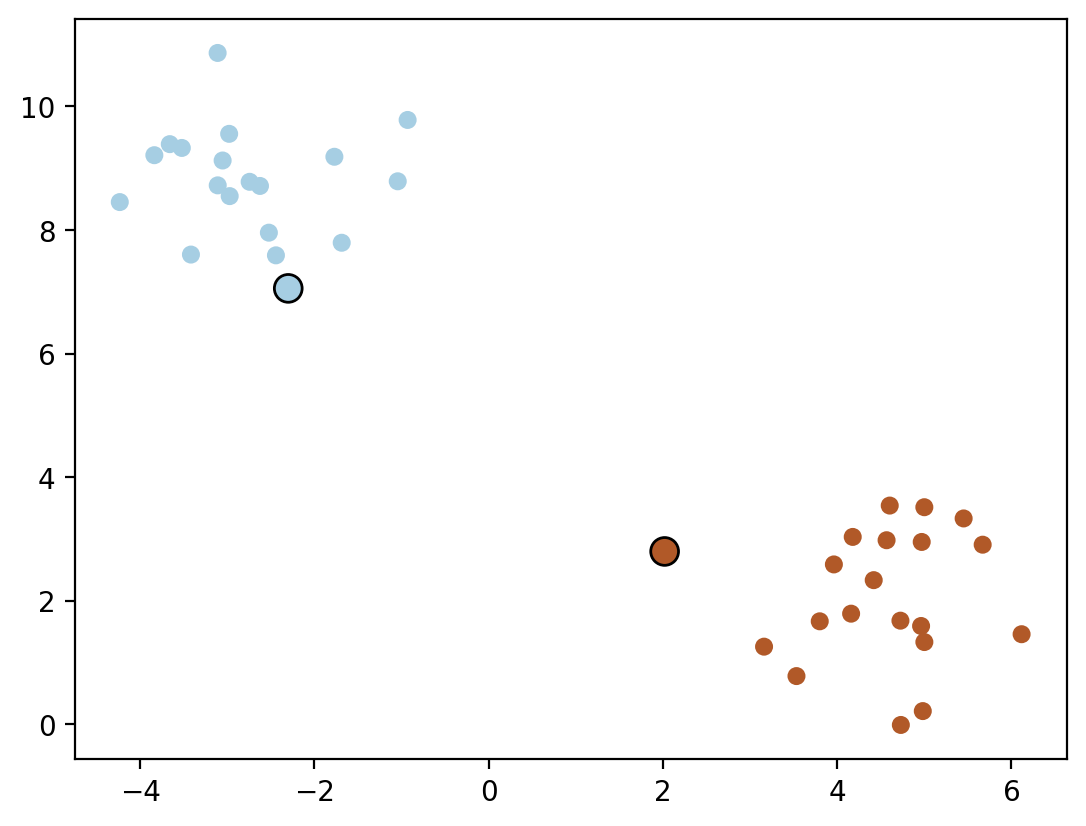

In [133]:
# Support vectors have non zero lagrange multipliers
sv = alphas_sol > 1e-5
ind = np.arange(len(alphas_sol))[sv]
a = alphas_sol[sv]
sv_x = X[sv]
sv_y = y[sv]

# Plot the support vectors
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# Mark the support vectors with thick black circles
plt.scatter(sv_x[:, 0], sv_x[:, 1], c=sv_y, s=100, cmap=plt.cm.Paired, marker='o', edgecolors='k')

In [134]:
w = np.sum(a * sv_y[:, None] * sv_x, axis=0)
w

array([ 0.23474316, -0.23143308])

In [135]:
b = np.sum(sv_y - np.dot(sv_x, w)) / len(sv_y)
b

1.1726593683601716

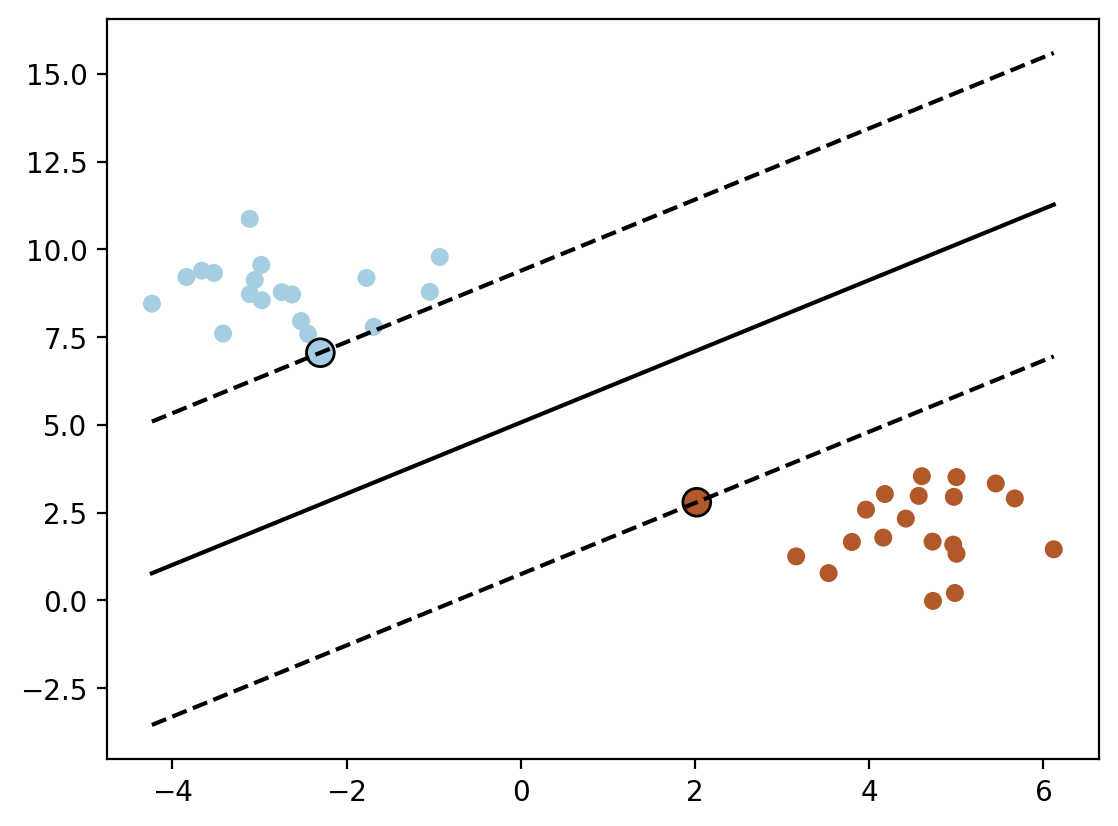

In [136]:
# Plot the decision boundary and margins
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
plt.scatter(sv_x[:, 0], sv_x[:, 1], c=sv_y, s=100, cmap=plt.cm.Paired, marker='o', edgecolors='k')

x_min = np.min(X[:, 0])
x_max = np.max(X[:, 0])

y_min = (-w[0] * x_min - b) / w[1]
y_max = (-w[0] * x_max - b) / w[1]

plt.plot([x_min, x_max], [y_min, y_max], 'k-')

# Margin 1
y_min = (-w[0] * x_min - b + 1) / w[1]
y_max = (-w[0] * x_max - b + 1) / w[1]

plt.plot([x_min, x_max], [y_min, y_max], 'k--')

# Margin 2
y_min = (-w[0] * x_min - b - 1) / w[1]
y_max = (-w[0] * x_max - b - 1) / w[1]

plt.plot([x_min, x_max], [y_min, y_max], 'k--')



### Using cvxpy

In [137]:
import cvxpy as cp

alpha = cp.Variable(n_samples)

inequality_constraints = [alpha >= 0]
equality_constraints = [cp.multiply(alpha, y) == 0]

overall_constraints = inequality_constraints + equality_constraints
P_numpy = np.outer(y, y)* K   + 3e-8 * np.eye(n_samples)
objective = cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(alpha, P_numpy))

prob = cp.Problem(objective, overall_constraints)
result = prob.solve()

In [138]:
prob.status
alpha.value.sort()
alpha.value

array([-1.49664286e-08, -7.86036073e-09, -7.48959975e-09, -4.95631234e-09,
       -4.80337014e-09, -4.21382858e-09, -4.17627547e-09, -3.60319297e-09,
       -2.54786233e-09, -1.86476801e-09, -1.28264318e-09, -6.50572915e-10,
       -3.44845584e-10, -4.45332158e-11,  2.50213529e-10,  2.67913419e-10,
        8.79522453e-10,  8.82710270e-10,  9.50098303e-10,  1.82268844e-09,
        2.74355414e-09,  3.45032195e-09,  4.95527787e-09,  5.02308218e-09,
        5.34165002e-09,  6.71939414e-09,  6.94177696e-09,  7.06890144e-09,
        9.38395895e-09,  9.49925189e-09,  9.72666606e-09,  1.15208492e-08,
        1.18351650e-08,  1.20920336e-08,  1.22215620e-08,  1.69516039e-08,
        2.28584041e-08,  3.45155480e-08,  5.49049991e-08,  1.01339280e-07])

### Primal using cvxopt

In [139]:
# Number of features
n_features = X.shape[1]

# Identity matrix
P = cvxopt.matrix(np.block([[np.eye(n_features), np.zeros((n_features, 1))], [np.zeros((1, n_features + 1))]]))

# Inequality constraints matrix
G = cvxopt.matrix(-np.block([np.diag(y) @ X, y.reshape(-1, 1)]))

# Inequality constraints bounds
h = cvxopt.matrix(-np.ones(X.shape[0]))

# Solve the QP problem
solution = cvxopt.solvers.qp(P, cvxopt.matrix(np.zeros(n_features + 1)), G, h)

# Extract optimized w and b values
w_opt = np.array(solution['x'][:-1])
b_opt = np.array(solution['x'][-1])

     pcost       dcost       gap    pres   dres
 0:  1.9726e-02  3.3304e+00  8e+01  2e+00  3e+02
 1:  1.2482e-01 -5.6113e+00  6e+00  1e-01  2e+01
 2:  1.3362e-01 -3.5560e-03  1e-01  4e-16  5e-15
 3:  5.5490e-02  3.7579e-02  2e-02  3e-16  3e-16
 4:  5.6104e-02  5.0978e-02  5e-03  2e-16  1e-16
 5:  5.4359e-02  5.4114e-02  2e-04  2e-16  1e-16
 6:  5.4336e-02  5.4321e-02  1e-05  2e-16  2e-15
 7:  5.4333e-02  5.4333e-02  1e-07  3e-16  2e-16
 8:  5.4333e-02  5.4333e-02  1e-09  2e-16  3e-16
Optimal solution found.

In [142]:
w_opt, w

(array([[ 0.23474325],
        [-0.23143308]]),
 array([ 0.23474316, -0.23143308]))

In [143]:
b_opt, b

(array(1.17265942), 1.1726593683601716)